# SMS Shape Notebook

## 準備 Preparation

In [ ]:
# 必要なパッケージをインストール
# Install the required packages
!pip install numpy matplotlib

In [2]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib import patches
import matplotlib.ticker as plticker
normalize = lambda x: x/np.linalg.norm(x)
tau = 2*np.pi

### 日本語を含む図の作成 <br> Making plot containing Japanese
日本語を含む図を作成する際に、次のパッケージをインストールしてimportする必要があります。  
If you are making plots containing Japanese, you have to install
and import the following package.

In [ ]:
!pip install japanize_matplotlib

In [ ]:
import japanize_matplotlib

### class of shapes
多角形と凸多面体を実装したクラス  
Classes that implement polygon and convex polyhedron

In [3]:
# 多角形
class Polygon():
  def __init__(self, verts):
    '''
    * self.verts:
      頂点の配列
      Array of vertices
    '''
    self.verts = np.array(verts)
  def clipLine(self, p, n, c=0):
    '''
    半平面 (x-p)・n >= c との共通部分の多角形を返す
    Return the intersection polygon with half plane (x-p)・n >= c
    * p:
      直線上の一点
      Any point on the line
    * n:
      直線の法線ベクトル
      Normal vector of the line
    * c:
      定数
      Constant
    '''
    p, n, c = map(array, (p, n, c))
    r = np.dot(self.verts-p, n)-c
    verts = []
    for i in range(len(r)):
      v0, r0 = self.verts[i-1], r[i-1]
      v1, r1 = self.verts[i], r[i]
      if r1 >= 0:
        if r0 < 0: # (- +)
          verts.append((r1*v0-r0*v1)/(-r0+r1))
        verts.append(v1)
      elif r0 >= 0: # (+ -)
        verts.append((-r1*v0+r0*v1)/(r0-r1))
    return Polygon(array(verts).reshape(-1, self.verts.shape[1]))
  def path(self, axis=(0, 1)):
    '''
    Get Path instance
    * axis:
      用いる軸を指定(デフォルト：xとy)
      - ``(0, 2)'': xとz
      - ``(2, 1)'': zとy
      The axes to use (Defaults: x, y)
      - ``(0, 2)'': x and z
      - ``(2, 1)'': z and y
    '''
    if self.verts.shape[0] == 0: return Path(np.zeros((0, 2)))
    verts = self.verts[:, axis]
    assert verts.shape[-1] == 2, 'verts should be 2D'
    return Path([*verts, (0, 0)], [
      Path.MOVETO,
      *(Path.LINETO for _ in range(1, verts.shape[0])),
      Path.CLOSEPOLY,
    ])
  def plot(self, axis=(0, 1), margin=0.05, facecolor='#2ee5b8', lw=1):
    '''
    この多角形を描画し、figとaxを返す
    Plot this polygon and return ``fig'' and ``ax''
    * axis:
      self.pathを参照
      See self.path
    * margin:
      Margin of the plot
    * facecolor:
      面の色
      Face color
    * lw:
      線の太さ
      Line width
    '''
    fig, ax = plt.subplots()
    if self.verts.shape[0] == 0: return fig, ax
    # path
    path = self.path(axis)
    patch = patches.PathPatch(path, facecolor=facecolor, lw=lw)
    ax.add_patch(patch)
    verts = self.verts[:, axis]
    xMax, yMax = verts.max(axis=0)
    xMin, yMin = verts.min(axis=0)
    xMg, yMg = verts.ptp(axis=0)*margin
    ax.set_xlim(xMin-xMg, xMax+xMg)
    ax.set_ylim(yMin-yMg, yMax+yMg)
    return fig, ax
  def __repr__(self):
    return f'Polygon with {len(self.verts)}vertices:\n{self.verts}'

# 多面体
class Polyhedron:
  def __init__(self, verts, edges):
    '''
    * self.verts:
      頂点の配列
      Array of vertices
    * self.edges:
      辺(2頂点の番号)の配列
      Array of edges (indices of 2 vertices)
    '''
    self.verts = np.array(verts)
    self.edges = edges
  def clipPlane(self, p, n, c=0):
    '''
    半空間 (x-p)・n >= c との共通部分の多面体を返す
    Return the intersection polyhedron with half space (x-p)・n >= c
    * p:
      平面上の一点
      Any point on the plane
    * n:
      直線の法線ベクトル
      Normal vector of the plane
    * c:
      定数
      Constant
    '''
    p, n, c = map(array, (p, n, c))
    r = np.dot(self.verts-p, n)-c
    rb = [s>=0 for s in r]
    # map vertex indices old to new
    io2n = {
      iO: iN
      for iN, iO in enumerate(iO for iO, sb in enumerate(rb) if sb)
    }
    # handle old vert
    verts = [v for v, sb in zip(self.verts, rb) if sb]
    edges = []
    for i0, i1 in self.edges:
      if rb[i0] and rb[i1]:
        # remain
        edges.append((io2n[i0], io2n[i1]))
      elif rb[i0] or rb[i1]:
        # new vert
        v0, r0 = self.verts[i0], abs(r[i0])
        v1, r1 = self.verts[i1], abs(r[i1])
        vN = (r1*v0+r0*v1)/(r0+r1)
        edges.append((io2n[i0 if rb[i0] else i1], len(verts)))
        verts.append(vN)
      # else drop edge
    # add new face
    nOld = len(io2n)
    vNews = verts[nOld:]
    if len(vNews):
      assert len(vNews) >= 3
      p0, p1 = vNews[:2]
      # choose p1-p0 as e1
      e1 = normalize(p1-p0)
      # choose e2 that ⊥ n, e1
      e2 = normalize(np.cross(n, e1))
      # set (p0+p1)/2 as new origin, and use {e1, e2} as new basis
      cNews = np.dot(vNews-(p0+p1)/2, array([e1, e2]).transpose())
      # indices of new verts CCW
      jNews = nOld+np.arctan2(cNews[:,0], cNews[:,1]).argsort()
      # add to edge
      for i in range(len(vNews)):
        edges.append((jNews[i-1], jNews[i]))
    # final
    return Polyhedron(array(verts).reshape(-1, self.verts.shape[1]), edges)
  def slicePlane(self, p, n):
    '''
    平面 (x-p)･n=0 との共通部分(多角形)の頂点を返す
    Return vertices of intersection(polygon) with plane (x-p)･n=0
    * p:
      平面上の一点
      Any point on the plane
    * n:
      平面の法線ベクトル
      Normal vector of the plane
    '''
    p, n = map(array, (p, n))
    r = np.dot(self.verts-p, n)
    vNews = []
    # handle old verts
    for i0, i1 in self.edges:
      # two vertices on other side of the plane
      if np.sign(r[i0]) != np.sign(r[i1]):
        v0, r0 = self.verts[i0], abs(r[i0])
        v1, r1 = self.verts[i1], abs(r[i1])
        vN = (r1*v0+r0*v1)/(r0+r1)
        vNews.append(vN)
    # new verts
    if len(vNews):
      assert len(vNews) >= 2
      p0, p1 = vNews[:2]
      e1 = normalize(p1-p0)
      e2 = normalize(np.cross(n, e1))
      cNews = np.dot(vNews-(p0+p1)/2, array([e1, e2]).transpose())
      jNews = np.arctan2(cNews[:,0], cNews[:,1]).argsort()
      return array([vNews[j] for j in jNews])
    else:
      return array(np.zeros((0, self.verts.shape[-1])))
  def __repr__(self):
    return 'Polyhedron with %d vertices and %d edges:\n%s'%(
      len(self.verts), len(self.edges),
      #'\n'.join(line for line in str(
      array([self.verts[[i0, i1]] for i0, i1 in self.edges])
      #).split('\n') if line)
    )

In [4]:
# 等高線図
def contourMap(poly, ys, colors, margin=0.05, lw=1):
  '''
  与えたy座標に対して多面体の等高線図を描画
  Plot a contour map of polyhedron with given y
  * poly:
    多面体
    Polyhedron
  * ys:
    等高線のy座標配列
    Array of y coordinate of the contour map
  * colors:
    各層の色の配列
    Array of colors of each layer
  * margin:
    Margin of the plot
  * lw:
    線の太さ
    Line width
  '''
  fig, ax = plt.subplots()
  xyMin = array([np.inf]*2)
  xyMax = -xyMin
  for y, color in zip(ys, colors):
    verts = poly.slicePlane((0, y, 0), (0, 1, 0))
    verts = verts[:, (0, 2)] # (x, z)
    path = Polygon(verts).path()
    ax.add_patch(patches.PathPatch(path, facecolor=color, lw=lw))
    # update xyMin, xyMax
    xyMin = np.min([xyMin, *verts], axis=0)
    xyMax = np.max([xyMax, *verts], axis=0)
  # 座標の範囲を設定
  # set range of coordinate
  xyRg = (xyMax-xyMin)*margin
  xyMax += xyRg
  xyMin -= xyRg
  ax.set_xlim(xyMin[0], xyMax[0])
  ax.set_ylim(xyMin[1], xyMax[1])
  return fig, ax

## すり抜け可能領域の可視化 <br> Visualization of the area that you can clip through

### 三角形の座標
調べたい三角形の座標を入力しましょう。例としてシレナINの地面三角形を使います。  
Fill in the coordinates of the triangle that you want to research on.
I will use the floor triangle of Sirena IN as an example.

In [ ]:
tri = array([
  (-331.148, 2064.531, 1757.190),
  (174.367, 2357.666, 1443.628),
  (-174.367, 2357.666, 1443.628),
])

hex形式の座標データを使う場合、次のように配列に変換することができます。  
If you use the hex form of the coordinate data,
you can convert it to array as shown below.

In [23]:
raw = 'C3 A5 92 F2 45 01 08 7F 44 DB A6 14 43 2E 5D F4 45 13 5A A8 44 B4 74 19 C3 2E 5D F4 45 13 5A A8 44 B4 74 19'
tri = np.frombuffer(bytes.fromhex(raw), '>f').astype('d').reshape(-1, 3)[:3, :]
tri

array([[-331.14801025, 2064.53100586, 1757.18994141],
       [ 174.36700439, 2357.66601562, 1443.62805176],
       [-174.36700439, 2357.66601562, 1443.62805176]])

### すり抜け可能領域 <br> The area that you can clip through
マリオの位置を`M`、水平速度を`vh`、鉛直速度を`vy`とし、三角形の境界は水平方向で`B`を通って`nB`を単位法線ベクトル(三角形外向き)とした直線とし、すり抜ける地面の高さを`yB`とすると、すり抜ける条件は次の通りです。  
1. `M`が三角形の上方にある
2. 1QF後マリオが地面の判定の下にいる：`M.y + vy/4 < yB-30`
3. 1QF後マリオが水平方向で境界を超える：`(M+vh/4-B)･nB > 0`

Let `M` be Mario's position,
`vh` be his horizontal speed, and `vy` be his vertical speed,
the border of the triangle be a line passes `B`
with normalized normal vector `nB` (point outward from the triangle)
horizontally, and the height of the triangle Mario that clips though be `yB`,
he can clip through the floor if the following conditions are met.
1. `M` is above the triangle
2. Mario is below the hitbox of the floor triangle after 1 QF: `M.y + vy/4 < yB-30`
3. Mario cross the border horizontally after 1 QF: `(M+vh/4-B)･nB > 0`

In [6]:
def getClipThroughArea(vh, vy, B, nB, yB):
  # 法線ベクトルを正規化
  # normalize normal vector
  nB = normalize(nB) 
  
  # 条件1において、三角形以上の領域は無限に続く三角柱であるが、
  # 無限の処理はややこしいため、ここでは適当な上限(yMax+75)を設けて
  # 多面体である三角柱にする。
  # For condition 1, the area above the triangle is a
  # triangular prism that extends infinitely.
  # However, it is difficult to deal with infinity,
  # and therefore we choose an appropriate upper bound (yMax+75)
  # and make the area a finite triangular prism.
  poly = Polyhedron([
    # 下の三角形 = 地面三角形
    # the bottom triangle = the floor triangle
    *tri,
    # 上の三角形：xとz座標を固定してyをyMax+75とする
    # the upper triangle: fix x and z coordinate and set y=yMax+75
    *(
      [v[0], tri[:,1].max()+75, v[2]]
      for v in tri
    )
  ], [
    e for i in range(3)
    for e in [
      # 下の三角形の辺
      # the edge of the bottom triangle
      (i, (i+1)%3),
      # 上の三角形の辺
      # the edge of the upper triangle
      (3+i, 3+(i+1)%3),
      # 下の三角形から上の三角形を繋ぐ辺
      # the edge that connect the bottom triangle and the upper triangle
      (i, 3+i),
    ]
  ])

  # 条件2において、M.y + vy/4 < yB-30より、
  # For confition 2, since M.y + vy/4 < yB-30,
  # -M.y > vy/4+30-yB
  # (M-0)･(0, -1, 0) > vy/4+30-yB
  poly = poly.clipPlane((0, 0, 0), (0, -1, 0), vy/4+30-yB)

  # 条件3において、(M-(B-vh/4))･nB > 0
  # For condition 3, (M-(B-vh/4))･nB > 0
  poly = poly.clipPlane(B-vh/4, nB)
  
  # 条件1~3を満たす領域はpolyとなる
  # Now the area satisfies condition 1.~3. is exactly poly
  return poly

シレナINの例で定数は次のように与えられたとすると、上記の関数を用いれば、すり抜け可能領域が求まります。  
In the Sirena IN example, suppose the constants are given as below.
You can then simply use the function above to get the area
that you can clip though.

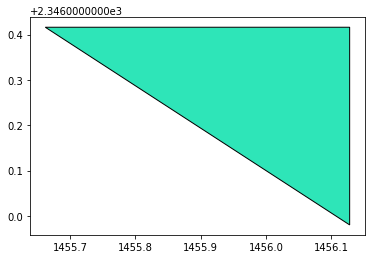

In [24]:
poly = getClipThroughArea(
  # 水平速度 horizontal speed
  vh = array([0, 0, -50]),
  # 鉛直速度 vertical speed
  vy = -75,
  # 境界上の一点 a point on the border
  B = tri[1],
  # 境界の法線ベクトル normal vector of the border
  # -(n.x, 0, n.z); n = cross(P1-P0, P2-P1) in game
  nB = np.cross(tri[0]-tri[1], tri[2]-tri[1])*(1, 0, 1),
  # すり抜ける地面の高さ
  # height of the triangle that Mario clips through
  yB = tri[1][1],
)

# x=0のときの断面図を描画。図の横軸をz軸(2)、縦軸をy軸(1)とする
# plot the cross section when x = 0
# use z(2) as horizontal axis and y(1) as vertical axis
fig, ax = Polygon(poly.slicePlane((0, 0, 0), (1, 0, 0))).plot(axis=(2, 1))
plt.show()

生成した図に関して、matplotlibで色々設定できます。  
You can configure the generated plot with matplotlib.

In [25]:
fig, ax = Polygon(poly.slicePlane((0, 0, 0), (1, 0, 0))[:,[2,1]]).plot()

# 図のサイズを設定 resize figure
fig.set_size_inches(6, 6)

# タイトルを設定
ax.set_title('SB Pipe (vy=-75, vz=-50)')
# x軸のラベルを設定
ax.set_xlabel('z')
# y軸のラベルを設定
ax.set_ylabel('y')

# 0.05刻みにする
# set tick interval to 0.05
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.05))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.05))

# ラベルのフォーマットを設定(xは目盛の値、iは番号)
# set the format of the labels
# (x is the value of the tick, and i is the index)
ax.xaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.2f'))

# x軸のラベルを30度回転
# rotate x label 30 deg
ax.xaxis.set_tick_params(rotation=30)

# グリッドを表示 show grid
ax.grid()

plt.show()

## 付録：本ライブラリによる図の描画 <br> Appendix: Plot with this library

毎回`fig.set_size_inches`でサイズを設定する代わりに、次の命令で図のデフォルトサイズを設定することができます。  
Instead of using `fig.set_size_inches` every time,
you can use the following instruction to set the default figure size.

In [ ]:
plt.rcParams["figure.figsize"] = (5, 5)

### 多角形 Polygon

例として、ある正七角形といくつかの半平面との共通部分の描画方法を示します。  
As an example, I will demonstrate how to draw the intersection polygon
of a regular heptagon (7-gon) and some half planes.

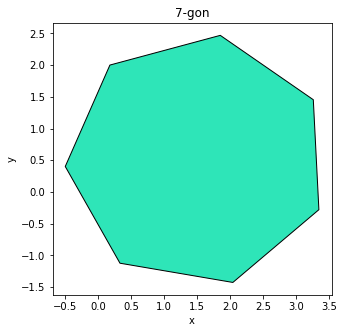

In [10]:
# (1.5, 0.5)を中心とし、外接円半径2、-0.4 radだけ回転した正七角形
# A heptagon with center (1, 0.5), circumradius 2, rotated 0.05 rad
poly0 = Polygon(array([
  [f(tau/7*i-0.4) for f in (np.cos, np.sin)]
  for i in range(7)
])*2+(1.5, 0.5))

# 描画 plot
fig, ax = poly0.plot()
# 図のサイズを設定 resize figure
fig.set_size_inches(5, 5)
# タイトルを設定
ax.set_title('7-gon')
# x軸のラベルを設定
ax.set_xlabel('x')
# y軸のラベルを設定
ax.set_ylabel('y')
plt.show()

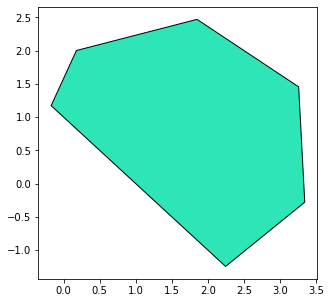

In [11]:
# x+y>=1 との共通部分を取る
# Take the intersection with x+y>=1
## P=(1, 0) n=(1, 1)
poly1 = poly0.clipLine((1, 0), (1, 1))
fig, ax = poly1.plot()
fig.set_size_inches(5, 5)
plt.show()

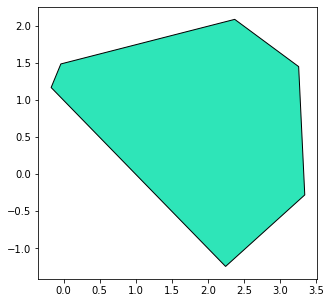

In [12]:
# 更に -x+4y<=6 との共通部分を取る
# Also take the intersection with -x+4y<=6
## P=(-6, 0) n=-(-1, 4)
poly2 = poly1.clipLine((-6, 0), (1, -4))
fig, ax = poly2.plot()
fig.set_size_inches(5, 5)
plt.show()

### 多面体 Polyhedron
例として、立方体といくつかの半空間との共通部分の**断面図**と**等高線図**の描画方法を示します。  
As an example, I will demonstrate how to plot the **cross section** and
**contour map** of the intersection of a cube and some half-spaces.

In [13]:
cube = Polyhedron([
  (i>>2&1, i>>1&1, i&1) for i in range(8)
], list({
  (i, j)
  for i in range(8)
  for j in (i^4, i^2, i^1)
  if i < j
}))

cube

Polyhedron with 8 vertices and 12 edges:
[[[0 0 0]
  [0 0 1]]

 [[0 0 0]
  [1 0 0]]

 [[0 0 1]
  [1 0 1]]

 [[0 1 1]
  [1 1 1]]

 [[1 0 0]
  [1 1 0]]

 [[1 0 1]
  [1 1 1]]

 [[0 1 0]
  [0 1 1]]

 [[1 1 0]
  [1 1 1]]

 [[0 0 0]
  [0 1 0]]

 [[1 0 0]
  [1 0 1]]

 [[0 1 0]
  [1 1 0]]

 [[0 0 1]
  [0 1 1]]]

In [14]:
# 2x+3y+4z<=5 との共通部分
# Intersection with x+y+z<=2
## P=(1,1,0), n=-(2,3,4)
poly3 = cube.clipPlane((1,1,0), (-2,-3,-4))
poly3

Polyhedron with 10 vertices and 15 edges:
[[[0.         0.         0.        ]
  [0.         0.         1.        ]]

 [[0.         0.         0.        ]
  [1.         0.         0.        ]]

 [[0.         0.         1.        ]
  [0.5        0.         1.        ]]

 [[1.         0.         0.        ]
  [1.         1.         0.        ]]

 [[0.         1.         0.        ]
  [0.         1.         0.5       ]]

 [[1.         1.         0.        ]
  [1.         1.         0.        ]]

 [[0.         0.         0.        ]
  [0.         1.         0.        ]]

 [[1.         0.         0.        ]
  [1.         0.         0.75      ]]

 [[0.         1.         0.        ]
  [1.         1.         0.        ]]

 [[0.         0.         1.        ]
  [0.         0.33333333 1.        ]]

 [[0.         1.         0.5       ]
  [0.         0.33333333 1.        ]]

 [[0.         0.33333333 1.        ]
  [0.5        0.         1.        ]]

 [[0.5        0.         1.        ]
  [1.    

vertices:
[[1.    0.5   0.   ]
 [1.    0.5   0.375]
 [0.    0.5   0.875]
 [0.    0.5   0.   ]]



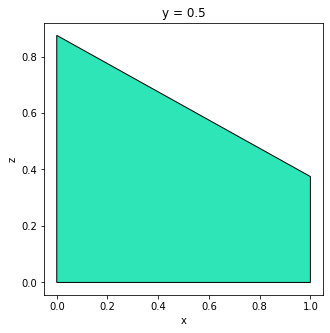

In [15]:
# y=0.5の時の断面図
# Cross section when y=0.5
## P=(0,0.5,0), n=(0,1,0)
cs3 = poly3.slicePlane((0, 0.5, 0), (0, 1, 0))
print('vertices:', cs3, sep='\n', end='\n\n')

# only use coordinate of x and z axis (0, 2)
fig, ax = Polygon(cs3[:, [0, 2]]).plot()
fig.set_size_inches(5, 5)
ax.set_title('y = 0.5')
ax.set_xlabel('x')
ax.set_ylabel('z')
plt.show()

等高線図は、複数の断面図の合成とみなせます。  
Contour map can be seen as composition of several cross sections.

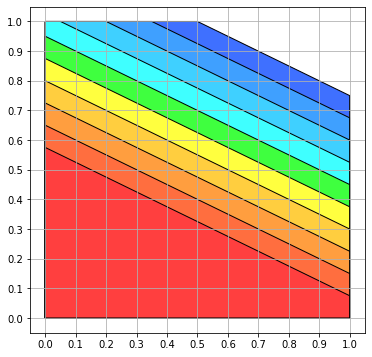

In [16]:
# y=0, 0.1, 0.2, ..., 1.0 とする
# Let y=0, 0.1, 0.2, ..., 1.0
ys = np.arange(11)/10

# 各層の色
# Colors for each layer
colors = [
  # red to yellow: 4
  *('#FF%02X3F'%g for g in 0x3F+191*np.arange(4)//4),
  # yellow to green: 1
  *('#%02XFF3F'%r for r in 0xFF-191*np.arange(1)//1),
  # green to cyan: 1
  *('#3FFF%02X'%b for b in 0x3F+191*np.arange(1)//1),
  # cyan to blue: 4
  *('#3F%02XFF'%g for g in 0xFF-191*np.arange(4)//4),
][::-1] # reverse order

# plot
fig, ax = contourMap(poly3, ys, colors)
fig.set_size_inches(6, 6)

# 0.1刻みにする
# set tick interval to 0.1
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.1))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.1))

# グリッドを表示
# show grid
ax.grid()

plt.show()

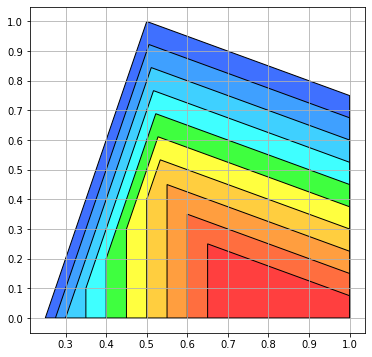

In [17]:
# 更に 4x-y-z>=1 と 2x-y>=0.4 との共通部分を取る
# Also take the intersection with 4x-y-z>=1 and 2x-y>=0.4
poly4 = poly3.clipPlane((0, 0, -1), (4, -1, -1))
poly4 = poly4.clipPlane((0.2, 0, 0), (2, -1, 0))

fig, ax = contourMap(poly4, ys, colors)
fig.set_size_inches(6, 6)

# 0.1刻みにする
# set tick interval to 0.1
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=0.1))
ax.yaxis.set_major_locator(plticker.MultipleLocator(base=0.1))

# グリッドを表示
# show grid
ax.grid()

plt.show()

## LICENSE